In [1]:
import re
import datetime
from math import log
import csv
import pprint
import math
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from scipy import stats
from elasticsearch import Elasticsearch, helpers

from __future__ import division

np.set_printoptions(threshold=np.inf)

%matplotlib inline

pp = pprint.PrettyPrinter()

In [2]:
username = 'es-atlas'
password = 'v~$&<J8/cG9]*eQ@'
es = Elasticsearch([{'host': 'es-atlas.cern.ch', 'port': 9203, 'http_auth': username+':'+password}], use_ssl=True,verify_certs=True,ca_certs="ca-bundle.trust.crt")

In [3]:
indices = es.cat.indices(index="atlas_tzjobs_*", h="index", request_timeout=600).split('\n')

In [4]:
def time_filter(indices, weeks=0, until=0):
    if weeks == 0:
        return ["atlas_tzjobs_*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%U-%w'   # assuming week starts on Sunday and week 0 is the first
    p = re.compile("atlas_tzjobs_(\d+)_week-(\d+)_v(\d+)")
    for i in indices:
        m = p.match(i)
        if m:
            year, week, version = m.group(1, 2, 3)
            day_str = '%s-%s-0' % (year, week)
            day = datetime.datetime.strptime(day_str, datefmt).date()
            diff = today - day
            if until <= diff.days / 7 < weeks + until:
                filtered.append(i.rstrip())
    return filtered

In [15]:
ind = time_filter(indices, 0, 0)
ind = ','.join(ind)
print ind

atlas_tzjobs_*


Important fields:
* ATLAS_release_number
* job_walltime_per_event
* machine.model_name
* machine.hepspec
* main_reco.wallTime
* main_reco_cpuTime_per_event
* mu
* mp_cpu_efficiency
* ncores (all 1?)
* ncores\*job_walltime
* nevents
* cpuTime
* reco_cputime_per_event
* singlecore_cpuTime
* singlecore_wallTime
* transform.cpuEfficiency
* transform.cpuTime
* transform.cpuTimeTotal
* transform.wallTime
* walltime


In [16]:
s = {
    "size":0,
    "aggs": {
        "atlrel": {
            "terms": {
                "field": "ATLAS_release_number",
                "size": 1000
            },
            "aggs": {
                "cputype": {
                    "terms": {
                        "field": "machine.model_name",
                        "size": 1000
                    },
                    "aggs": {
                        "task": {
                            "terms": {
                                "field": "taskid",
                                "size": 100000
                            },
                            "aggs": {
                                "1": {
                                    "extended_stats": {
                                        "script": {
                                            "inline": "(doc['nevents'].value) ? doc['cpuTime'].value / doc['nevents'].value : 0",
                                            "lang": "expression"
                                        }
                                    }
                                },
                                "2": {
                                    "extended_stats": {
                                        "script": {
                                            "inline": "(doc['nevents'].value) ? doc['walltime'].value * doc['ncores'].value / doc['nevents'].value : 0",
                                            "lang": "expression"
                                        }
                                    }
                                },
                                "3": {
                                    "sum": {
                                        "field": "cpuTime"
                                    }
                                },
                                "4": {
                                    "sum": {
                                        "script": {
                                            "inline": "doc['walltime'].value * doc['ncores'].value",
                                            "lang": "expression"
                                        }
                                    }
                                },
                                "5": {
                                    "avg": {
                                        "field": "ncores"
                                    }
                                },
                                "7": {
                                    "sum": {
                                        "field": "nevents"
                                    }
                                },
                                "8": {
                                    "avg": {
                                        "script": {
                                            "inline": "doc['cpuTime'].value / doc['walltime'].value / doc['ncores'].value",
                                            "lang": "expression"
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}
res = es.search(index=ind, body=s, request_timeout=12000)

In [17]:
output_file = 't0_cpu_x.csv'

In [18]:
with open(output_file, 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    buckets1 = res['aggregations']['atlrel']['buckets']
    for b1 in buckets1:
        atlrel = b1['key']
        buckets2 = b1['cputype']['buckets']
        for b2 in buckets2:
            cputype = b2['key']
            buckets3 = b2['task']['buckets']
            for b3 in buckets3:
                task = b3['key']
                writer.writerow([
                        task,
                        atlrel,
                        cputype,
                        b3['1']['count'],
                        b3['1']['avg'],
                        b3['1']['std_deviation'],
                        b3['2']['avg'],
                        b3['2']['std_deviation'],
                        b3['3']['value'],
                        b3['4']['value'],
                        b3['5']['value'],
                        b3['7']['value'],
                        b3['8']['value']
                    ])

In [19]:
input_file = 't0_cpu_x.csv'

In [20]:
df = pd.read_csv(input_file, dtype={'cpu_n': 'float'}, names=['jeditaskid', 'atlrel', 'cputype', 'njobs',
                                                              'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg', 'wallevt_rms',
                                                              'cpu', 'wc', 'cores', 'jevts', 'eff'])

In [24]:
df[:10]

,jeditaskid,atlrel,cputype,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,wc,cores,jevts,eff
0,2111265,20.7.6.7,Intel(R)_Xeon(R)_CPU_E5-2630_v3_@_2.40GHz,43524,10.002530,5.136370,10.971754,9.576847,1.073727e+09,1.163553e+09,1.0,113917857.0,0.915816
1,2109752,20.7.6.7,Intel(R)_Xeon(R)_CPU_E5-2630_v3_@_2.40GHz,36103,10.092488,13.162943,10.917502,23.468211,8.107089e+08,8.434884e+08,1.0,88923350.0,0.954867
2,2113627,20.7.6.7,Intel(R)_Xeon(R)_CPU_E5-2630_v3_@_2.40GHz,32811,11.638453,5.033269,12.104210,6.643941,8.684190e+08,9.011209e+08,1.0,77557996.0,0.964874
3,2112810,20.7.6.7,Intel(R)_Xeon(R)_CPU_E5-2630_v3_@_2.40GHz,31677,11.625101,4.772562,12.421811,11.303404,8.382515e+08,8.899314e+08,1.0,74533800.0,0.940577
4,2113406,20.7.6.7,Intel(R)_Xeon(R)_CPU_E5-2630_v3_@_2.40GHz,29263,11.763393,4.099992,12.429462,4.794509,7.830508e+08,8.295147e+08,1.0,69130223.0,0.946720
5,2109244,20.7.6.7,Intel(R)_Xeon(R)_CPU_E5-2630_v3_@_2.40GHz,27852,8.882553,8.205608,9.809727,15.236611,5.796080e+08,6.136641e+08,1.0,70609837.0,0.938682
6,2113892,20.7.6.7,Intel(R)_Xeon(R)_CPU_E5-2630_v3_@_2.40GHz,27754,12.003995,7.745318,12.439303,10.523989,7.447470e+08,7.681989e+08,1.0,64662340.0,0.967868
7,2134560,20.7.6.7,Intel(R)_Xeon(R)_CPU_E5-2630_v3_@_2.40GHz,26820,12.671567,5.549309,13.280890,6.817863,7.412937e+08,7.753488e+08,1.0,61236159.0,0.953987
8,2110757,20.7.6.7,Intel(R)_Xeon(R)_CPU_E5-2630_v3_@_2.40GHz,26507,12.408492,13.557220,14.401419,47.016221,6.338429e+08,6.686036e+08,1.0,55461293.0,0.933431
9,2115577,20.7.6.7,Intel(R)_Xeon(R)_CPU_E5-2630_v3_@_2.40GHz,26151,10.940262,7.310882,11.375847,9.743731,6.544853e+08,6.774524e+08,1.0,62217579.0,0.964573


In [26]:
df['cputype'].unique()

array(['Intel(R)_Xeon(R)_CPU_E5-2630_v3_@_2.40GHz',
       'Intel(R)_Xeon(R)_CPU_E5-2630L_0_@_2.00GHz',
       'Intel(R)_Xeon(R)_CPU_E5-2650_v2_@_2.60GHz',
       'Intel(R)_Xeon(R)_CPU_E5-2650_0_@_2.00GHz',
       'AMD_Opteron(TM)_Processor_6276',
       'Intel(R)_Xeon(R)_CPU___________L5520__@_2.27GHz'], dtype=object)

20177127.6229


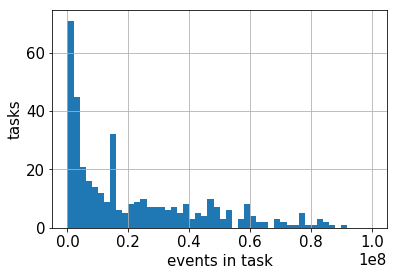

In [35]:
grouped = df.groupby(['jeditaskid'], as_index=False)
a = grouped['jevts'].sum()
print stats.trim_mean(a['jevts'], 0.05)
fig = a['jevts'].hist(bins=50, range=[0., 1e8], log=False)
plt.xlabel('events in task')
plt.ylabel('tasks')

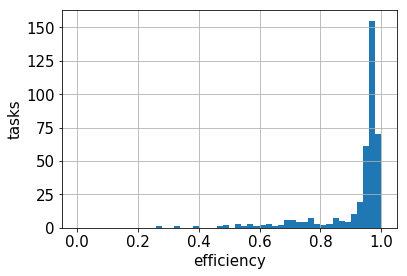

In [39]:
grouped = df.groupby(['jeditaskid'], as_index=False)
a = grouped['eff'].mean()
fig = a['eff'].hist(bins=50, log=False, range=(0., 1.))   # NOT VERY CORRECT (arithmetic mean of efficiencies...)
plt.xlabel('efficiency')
plt.ylabel('tasks')

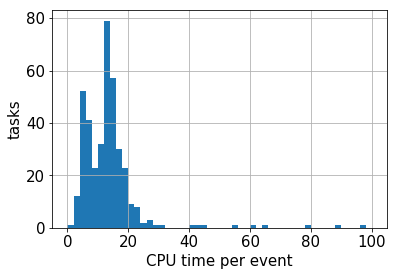

In [44]:
a = grouped['cpuevt_avg'].mean()
fig = a['cpuevt_avg'].hist(bins=50, log=False, range=(0., 100.))   # NOT VERY CORRECT (arithmetic mean of efficiencies...)
plt.xlabel('CPU time per event')
plt.ylabel('tasks')

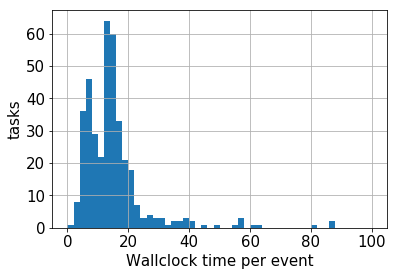

In [46]:
a = grouped['wallevt_avg'].mean()
fig = a['wallevt_avg'].hist(bins=50, log=False, range=(0., 100.))   # NOT VERY CORRECT (arithmetic mean of efficiencies...)
plt.xlabel('Wallclock time per event')
plt.ylabel('tasks')

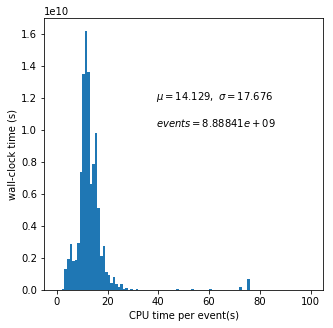

In [58]:
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
var = 'cpuevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

mean = np.average(df[var], weights=df['wc'])   # average time weighted with no. of events
std = math.sqrt(np.average((df[var] - mean)**2, weights=df['wc']))
range = [0., 100.]
sp = plt.subplot(1, 1, i)
plt.hist(df[var].tolist(), bins=100, range=range, weights=df['wc'].tolist(), log=log_scale)   # integral is total no. of events
plt.xlabel('CPU time per event(s)')
plt.ylabel('wall-clock time (s)')
t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
stat = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
stat2 = r'$\mathit{events}=%g$' % df['jevts'].sum()
if log_scale:
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, '\n')
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stat)
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stat2)
else:
    plt.text(t_x(.4), t_y(.8), '\n')
    plt.text(t_x(.4), t_y(.7), stat)
    plt.text(t_x(.4), t_y(.6), stat2)

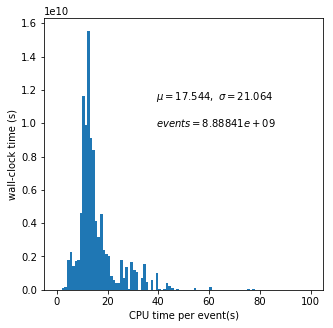

In [59]:
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
var = 'wallevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

mean = np.average(df[var], weights=df['wc'])   # average time weighted with no. of events
std = math.sqrt(np.average((df[var] - mean)**2, weights=df['wc']))
range = [0., 100.]
sp = plt.subplot(1, 1, i)
plt.hist(df[var].tolist(), bins=100, range=range, weights=df['wc'].tolist(), log=log_scale)   # integral is total no. of events
plt.xlabel('CPU time per event(s)')
plt.ylabel('wall-clock time (s)')
t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
stat = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
stat2 = r'$\mathit{events}=%g$' % df['jevts'].sum()
if log_scale:
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, '\n')
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stat)
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stat2)
else:
    plt.text(t_x(.4), t_y(.8), '\n')
    plt.text(t_x(.4), t_y(.7), stat)
    plt.text(t_x(.4), t_y(.6), stat2)

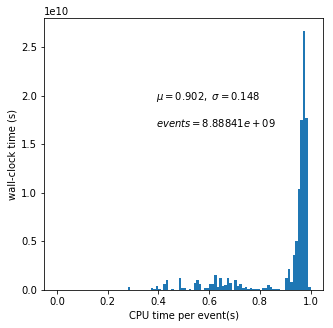

In [60]:
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
var = 'eff'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

mean = np.average(df[var], weights=df['wc'])   # average time weighted with no. of events
std = math.sqrt(np.average((df[var] - mean)**2, weights=df['wc']))
range = [0., 1.]
sp = plt.subplot(1, 1, i)
plt.hist(df[var].tolist(), bins=100, range=range, weights=df['wc'].tolist(), log=log_scale)   # integral is total no. of events
plt.xlabel('CPU time per event(s)')
plt.ylabel('wall-clock time (s)')
t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
stat = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
stat2 = r'$\mathit{events}=%g$' % df['jevts'].sum()
if log_scale:
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, '\n')
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stat)
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stat2)
else:
    plt.text(t_x(.4), t_y(.8), '\n')
    plt.text(t_x(.4), t_y(.7), stat)
    plt.text(t_x(.4), t_y(.6), stat2)